In [1]:
import numpy as np
import vegas
from constants import *
import supernovaNuBoostedDM as svbdm
import matplotlib.pyplot as plt
from functools import partial

In [24]:
import multiprocessing as mp

In [2]:
# Define legacy functions

def gamma(Ev,mx):
    """
    Calculate gamma factor in CM frame
    """
    s = mx**2+2*Ev*mx
    Ecm = 0.5*(s+mx**2)/np.sqrt(s)
    return Ecm/mx


def g(Ev,mx,psi):
    """
    Calculate BDM angular distribution dndOmega
    
    Input
    ------
    Enu: Neutrino energy
    mx: DM mass
    psi: lab frame scattering angle in [0,Pi/2]
    
    Output
    ------
    g: PDF of scattering angle alpha
    """ 
    if 0 <= psi <= np.pi/2 and Ev > 0:
        gm = gamma(Ev,mx)
        sec = 1/np.cos(psi)
        dndOmega = gm**2*sec**3/np.pi/(1+gm**2*np.tan(psi)**2)**2
    else:
        dndOmega = 0
    return dndOmega


def dEv(Tx,mx,psi):
    """
    Calculate dEv/dTx via analytical expression. Note that the given
    inputs must lead to positive Ev or the corresponding dEvdTx would
    be unphysical
    
    Input
    ------
    Tx: DM kinetic energy
    mx: DM mass
    psi: scattering angle in lab frame
    
    Output
    ------
    dEv/dTx: the derivative of Ev over Tx
    """
    sec = 1/np.cos(psi)
    numerator = mx**2*sec*(2*sec*np.sqrt(Tx*(2*mx + Tx)) + 2*mx + Tx*sec**2 + Tx)
    denominator = (Tx*np.tan(psi)**2 - 2*mx)**2*np.sqrt(Tx*(2*mx + Tx))
    return numerator/denominator


def getJx(Tx,mx,psi,r,D,sigxv=1e-45,tau=10,Lv=Lv):
    """
    BDM emissivity at shell r, note the returned result is divided by sigxv and dimensionless DM velocity
    
    Input
    ------
    Tx: DM kinetic energy, MeV
    mx: DM mass, MeV
    psi: the scattering angle in lab frame
    r: the distance from the scattering point to GC, in kpc
    sigxv: DM-neutrino cross section, cm^2
    tau: the duration of SN explosion, default 10 s
    Lv: neutrino luminosity during the SN explosion, default 1e52 erg/s
        note that the total luminosity released by a single SN explosion
        should be Lv times the duration of that explosion, where the unit
        per second will be eliminated from this procedure
    
    Output
    ------
    BDM emissivity: in the unit of per cm^3 per second
    """
    # if Tx >= 2mx/tan(a)^2, Ev will turn negative (diverge at equal) which is unphysical
    if Tx < 2*mx/np.tan(psi)**2:
        Ev = svbdm.getEv(Tx, mx, psi)
        dEdT = svbdm.dEv(Tx,mx,psi)
        jx = svbdm.dnv(D,Ev,Lv,tau)*g(Ev,mx,psi)*dEdT*lightSpeed*svbdm.nx(r,mx)*tau*sigxv
    else:
        jx = 0
    return jx

In [3]:
def diffFluxAtEarth(t,Tx,mx,Rstar,theta,phi,beta,sigxv=1e-45,Re=8.5,r_cut=1e-5,tau=10): # (t,theta,Tx,mx,tau=10,sigxv=1e-45,Lv=Lv,R=R_MW,r_cut=1e-5,kind='MW',dtype=None,legacy=False):
    """
    The differential BDM flux over open angle theta at Earth
    
    Input
    ------
    t: The differential BDM flux at time t, relative to the first SN neutrino
        arriving at Earth
    Tx: BDM kinetic energy, MeV
    mx: DM mass, MeV
    Rstar: Distance from Earth to SN, kpc
    theta: The open angle theta
    phi: The azimuthal angle along the Earth-SN axis, rad
    beta: The deviation angle, characterizing how SN deviates the GC, rad
    sigxv: DM-neutrino cross section, default 1e-45 cm^2
    Re: The distance from Earth to GC, default 8.5 kpc
    r_cut: Ignore the BDM contribution when r' < r_cut, default 1e-5 kpc
    tau: The duration of SN explosion, default 10 s
    
    Output
    ------
    scalar: The diff. BDM flux at Earth, # per MeV per cm^2 per second per sr
    """
    # Get BDM velocity
    vx = svbdm.getVelocity(Tx,mx)
    # Get the propagation length of BDM via given t and vx
    d = svbdm.getd(t,vx,Rstar,theta)
    # Get the required SNv propagation length
    D = svbdm.getD(d,Rstar,theta)
    # Get the distance between boosted point to GC
    rprime = svbdm.getRprime(d,Re,theta,phi,beta)
    
    if  D != 0.0 and ~np.isnan(rprime) and rprime >= r_cut:
        # Get the BDM scattering angle psi
        psi = np.arccos(svbdm.getCosPsi(d,Rstar,theta))
        # Evaluate the xemissivity
        jx = getJx(Tx,mx,psi,rprime,D,sigxv,tau,Lv)
        # Jacobian
        J = lightSpeed/((d - Rstar*np.cos(theta))/D + 1/vx)
        # BDM flux
        return J*jx*vx*np.sin(theta)
    else:
        return 0
    
    #if adopt:
    #    J = c/((l - R*kpc2cm*np.cos(theta,dtype=dtype))/r + 1/vdm)
    #    return 2*np.pi*J*sigxv*xemissivity(Tx,mx,alpha,r/kpc2cm,tau,Lv,kind)*np.sin(theta,dtype=dtype)*vdm
    #else:
    #    return 0

In [116]:
Tx = 15
mx = 1e-2
Rstar1 = 5
Rstar2 = 8.5
Rstar3 = 12
beta1 = 0
beta2 = 0.1
beta3 = 1
totalNum = 100
integ = vegas.Integrator([[0,np.pi/2],[0,2*np.pi]])
tvan1,_ = svbdm.get_tvan_thetaM(Tx,mx,Rstar1)
tvan2,_ = svbdm.get_tvan_thetaM(Tx,mx,Rstar2)
tvan3,_ = svbdm.get_tvan_thetaM(Tx,mx,Rstar3)
tRange1 = np.logspace(np.log10(1e-3*yr2s),np.log10(tvan1),totalNum)
tRange2 = np.logspace(np.log10(1e-3*yr2s),np.log10(tvan2),totalNum)
tRange3 = np.logspace(np.log10(1e-3*yr2s),np.log10(tvan3),totalNum)
count = 1
result1 = []
result2 = []
result3 = []
count = 1
for t in tRange1:
    
    def _targetFunc(x):
        theta = x[0]
        phi = x[1]
        return diffFluxAtEarth(t,Tx,mx,Rstar1,theta,phi,beta1)
    
    result1.append(integ(_targetFunc, nitn=10, neval=5000).mean*1e10)
    print(f'{count} out of {3*totalNum} are completed',end='\r')
    count += 1
    
for t in tRange2:
    
    def _targetFunc(x):
        theta = x[0]
        phi = x[1]
        return diffFluxAtEarth(t,Tx,mx,Rstar2,theta,phi,beta1)
    
    result2.append(integ(_targetFunc, nitn=10, neval=5000).mean*1e10)
    print(f'{count} out of {3*totalNum} are completed',end='\r')
    count += 1
    
for t in tRange3:
    
    def _targetFunc(x):
        theta = x[0]
        phi = x[1]
        return diffFluxAtEarth(t,Tx,mx,Rstar3,theta,phi,beta1)
    
    result3.append(integ(_targetFunc, nitn=10, neval=5000).mean*1e10)
    print(f'{count} out of {3*totalNum} are completed',end='\r')
    count += 1
    #result2.append(integ(partial(_targetFunc,Rstar=Rstar2), nitn=10, neval=5000).mean*1e10)
    #result3.append(integ(partial(_targetFunc,Rstar=Rstar3), nitn=10, neval=5000).mean*1e10)
    #print(f'{count} out of {totalNum} are completed',end='\r')
    #count += 1

/var/folders/qf/n6502vwn5yz_j_q3fyn7nt140000gn/T/ipykernel_68472/947202710.py:79: RuntimeWarning: divide by zero encountered in double_scalars
  if Tx < 2*mx/np.tan(psi)**2:


In [27]:
result1 = np.loadtxt('beta0_Tx15_mx1e-2_sigxv1e-35_Rs5.txt',skiprows=1)
result2 = np.loadtxt('beta0_Tx15_mx1e-2_sigxv1e-35_Rs8.5.txt',skiprows=1)
result3 = np.loadtxt('beta0_Tx15_mx1e-2_sigxv1e-35_Rs12.txt',skiprows=1)

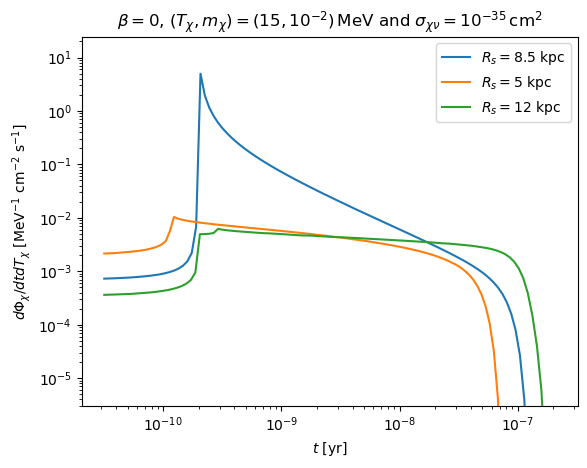

In [39]:
plt.plot(result2[:,0]/yr2s,result2[:,1],label=r'$R_s=8.5$ kpc')
plt.plot(result1[:,0]/yr2s,result1[:,1],label=r'$R_s=5$ kpc')
plt.plot(result3[:,0]/yr2s,result3[:,1],label=r'$R_s=12$ kpc')
plt.title(r'$\beta=0$, $(T_\chi,m_\chi)=(15,10^{-2})\,$MeV and $\sigma_{\chi\nu}=10^{-35}\,{\rm cm^2}$')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.ylim(3e-6,)
plt.xlabel(r'$t$ [yr]')
plt.ylabel(r'$d\Phi_\chi/dtdT_\chi~[{\rm MeV^{-1}~cm^{-2}~s^{-1}}]$')
plt.savefig('BDMFlux_model-agnostic_beta0_vs_Rs.pdf',bbox_inches='tight')

In [121]:
np.savetxt('beta0_Tx15_mx1e-2_sigxv1e-35_Rs12.txt',np.vstack((tRange3/yr2s,np.array(result3))).T,fmt='%.5e  %.5e',header='year       flux')

In [6]:
# Versus phi and theta
Tx = 15
mx = 1e-2
Rstar1 = 5
Rstar2 = 8.5
Rstar3 = 12
beta1 = 0*np.pi
beta2 = 0.05*np.pi
beta3 = 0.2*np.pi
phi_num = 20
theta_num = 25
totalNum = phi_num*theta_num

tvan1,thetaM1 = svbdm.get_tvan_thetaM(Tx,mx,Rstar1)
integ = vegas.Integrator([[10,tvan1],[5,100]])

#tvan2,_ = svbdm.get_tvan_thetaM(Tx,mx,Rstar2)
#tvan3,_ = svbdm.get_tvan_thetaM(Tx,mx,Rstar3)
#tRange1 = np.logspace(np.log10(1e-3*yr2s),np.log10(tvan1),totalNum)
#tRange2 = np.logspace(np.log10(1e-3*yr2s),np.log10(tvan2),totalNum)
#tRange3 = np.logspace(np.log10(1e-3*yr2s),np.log10(tvan3),totalNum)
result_phi = []
#result2 = []
#result3 = []
count = 1
for phi in np.linspace(0,2*np.pi,phi_num):
    result_theta = []
    for theta in np.linspace(0,2*thetaM1,theta_num):
    
        def _targetFunc(x):
            t = x[0]
            Tx = x[1]
            return diffFluxAtEarth(t,Tx,mx,Rstar1,theta,phi,beta2)
    
        result_theta.append(integ(_targetFunc, nitn=10, neval=5000).mean*1e10)
        print(f'{count} out of {totalNum} are completed',end='\r')
        count += 1
    result_phi.append(result_theta)
result_phi = np.array(result_phi)    
#for t in tRange2:
#    
#    def _targetFunc(x):
#        theta = x[0]
#        phi = x[1]
#        return diffFluxAtEarth(t,Tx,mx,Rstar2,theta,phi,beta1)
    
#    result2.append(integ(_targetFunc, nitn=10, neval=5000).mean*1e10)
#    print(f'{count} out of {3*totalNum} are completed',end='\r')
#    count += 1
    
#for t in tRange3:
    
#    def _targetFunc(x):
#        theta = x[0]
#        phi = x[1]
#        return diffFluxAtEarth(t,Tx,mx,Rstar3,theta,phi,beta1)
    
#    result3.append(integ(_targetFunc, nitn=10, neval=5000).mean*1e10)
#    print(f'{count} out of {3*totalNum} are completed',end='\r')
#    count += 1
    #result2.append(integ(partial(_targetFunc,Rstar=Rstar2), nitn=10, neval=5000).mean*1e10)
    #result3.append(integ(partial(_targetFunc,Rstar=Rstar3), nitn=10, neval=5000).mean*1e10)
    #print(f'{count} out of {totalNum} are completed',end='\r')
    #count += 1

/var/folders/dr/w2wmjyk173551q0j44jf3fnr0000gn/T/ipykernel_329/947202710.py:79: RuntimeWarning: divide by zero encountered in double_scalars
  if Tx < 2*mx/np.tan(psi)**2:


In [14]:
from matplotlib import colors

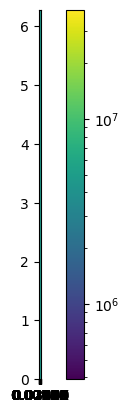

In [23]:
im =plt.imshow(result_phi, norm=colors.LogNorm(), extent=[0,2*thetaM1,0,2*np.pi])
plt.xticks(np.linspace(0,2*thetaM1,theta_num))
plt.colorbar(im)

In [13]:
result_phi

array([[       0.        , 38792440.60956776, 30181769.79245688,
        24261142.54932215, 19850190.04679964, 16321255.55109546,
        13329754.94776064, 10839389.24358775,  8799902.14200621,
         7150419.67645649,  5808806.51666016,  4734013.84398401,
         3861537.83013781,  3154893.79690028,  2586135.24312383,
         2124402.81256995,  1748849.07697623,  1443421.18549833,
         1193519.12336574,   988229.9875675 ,   820358.41884572,
          681643.81504722,   566892.00614204,   471276.00372148,
          391360.57643972],
       [       0.        , 37540461.99462914, 30267876.06537126,
        24261606.21735481, 19898598.08065762, 16350111.20929008,
        13318823.47356227, 10841134.47478818,  8806022.85055496,
         7153754.5562914 ,  5815601.55448147,  4733640.22123958,
         3860190.16674301,  3155997.96713624,  2586977.0671935 ,
         2124029.60484541,  1749042.38649412,  1443249.94157736,
         1193412.75620667,   989047.91462177,   820237.7942358

In [26]:
def worker(num):
    """Worker function"""
    print(f'Worker {num} starting')
    return

if __name__ == '__main__':
    # Define the number of workers to create
    num_workers = 4
    
    # Create the worker pool
    pool = mp.Pool(num_workers)
    
    # Start the workers
    pool.map(worker, range(num_workers))


Process SpawnPoolWorker-3:
Process SpawnPoolWorker-1:
Process SpawnPoolWorker-2:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/yenhsun/opt/anaconda3/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/yenhsun/opt/anaconda3/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/yenhsun/opt/anaconda3/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/yenhsun/opt/anaconda3/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/yenhsun/opt/anaconda3/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Users/yenhsun/opt/anaconda3/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Users/yenhsun/opt/anaconda3/lib/python3.9/multiproces

KeyboardInterrupt: 